## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('credit_scoring.csv')
df.columns = df.columns.str.lower()

In [4]:
df.head(2).T

,0,1
status,1,1
seniority,9,17
home,1,1
time,60,60
age,30,58
marital,2,3
records,1,1
job,3,1
expenses,73,48
income,129,131


Some of the features are encoded as numbers. Use the following code to de-code them:

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [9]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)

In [11]:
categorical

['home', 'marital', 'records', 'job']

In [14]:
numerical.remove('default')

In [15]:
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [16]:
from sklearn.model_selection import train_test_split

In [18]:
df_full_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
df_train, df_val = train_test_split(df_full_train, train_size=0.75, random_state=1)

In [19]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [21]:
df_full_train = df_full_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [22]:
y_full_train = df_full_train.default.values
y_test = df_test.default.values
y_train = df_train.default.values
y_val = df_val.default.values

In [23]:
del df_full_train['default']
del df_test['default']
del df_val['default']
del df_train['default']

In [24]:
df.default.value_counts()

0    3200
1    1254
Name: default, dtype: int64

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the default variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

array([0.25      , 0.33333333, 0.19444444, ..., 0.19444444, 0.19444444,
       0.32777778])

In [61]:
for n in numerical:
    roc_auc = roc_auc_score( y_train, df_train[n])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[n])
    print('%s: %.3f' % (n, roc_auc))

seniority: 0.709
time: 0.561
age: 0.573
expenses: 0.501
income: 0.682
assets: 0.649
debt: 0.505
amount: 0.591
price: 0.504


Which numerical variable (among the following 4) has the highest AUC?

- <b>seniority</b>
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [71]:
used_columns = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [72]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [82]:
def train(df_train, y_train, C = 1.0):
    dicts = df_train[used_columns].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [83]:
dv, model = train(df_train[used_columns], y_train)

In [84]:
def predict (df, dv, model):
    X = dv.transform(df[used_columns].to_dict(orient = 'records'))
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [85]:
roc_auc_score(y_val, predict(df_val, dv, model)).round(3)

0.811

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- <b> 0.812 </b>

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [100]:
y_pred = predict(df_val, dv, model)
precisions = []
recalls = []
tresholds = np.linspace(0.0, 1.0, 101)
for t in tresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)
    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()
    precision = 1.0 if tp == tp + fp else tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)

In [99]:
from matplotlib import pyplot as plt

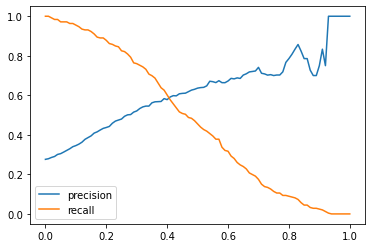

In [101]:
plt.plot(tresholds, precisions, label = 'precision')
plt.plot(tresholds, recalls, label = 'recall')
plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* <b>0.4</b>
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [106]:
y_pred = predict(df_val, dv, model)
precisions = []
recalls = []
tresholds = np.linspace(0.0, 1.0, 101)
f1_arr = []
for t in tresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predicted_positive = (y_pred >= t)
    predicted_negative = (y_pred < t)
    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()
    precision = 1.0 if tp == tp + fp else tp / (tp + fp)
    recall = tp / (tp + fn)
    precisions.append(precision)
    recalls.append(recall)
    f1 = 2 * (precision * recall) / (precision + recall)
    f1_arr.append(f1)

In [117]:
tresholds[np.array(f1_arr).argmax()]

0.32

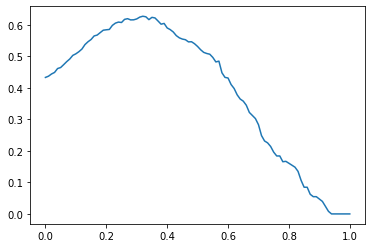

In [118]:
plt.plot(tresholds, f1_arr)

At which threshold F1 is maximal?

- 0.1
- <b> 0.3 </b>
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [119]:
from sklearn.model_selection import KFold

In [121]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [124]:
from tqdm.auto import tqdm

In [134]:
# answer for both questions
n_splits = 5
for c in tqdm([0.01, 0.1, 1, 10]):    
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    for train_idx, val_idx in \
    kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        scores.append(roc_auc_score(y_val, y_pred))
    print('C = %s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C = 0.01 0.809 +- 0.013
C = 0.1 0.813 +- 0.014
C = 1 0.813 +- 0.015
C = 10 0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- <b>0.014</b>
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- <b>10</b>

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.